In [1]:
%matplotlib inline
import d2ltvm
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import tvm
from tvm import te

successd...



# numpy mode

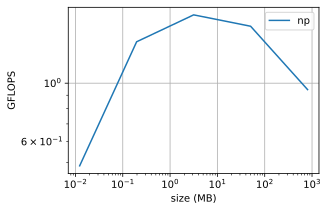

In [11]:
sizes = 2 ** np.arange(5, 15, 2)
np_broad_add = lambda s1, s2: timeit.Timer(setup='import numpy as np\n'
                                              'import d2ltvm\n'
                                              'a, b, c = d2ltvm.get_broad_data(%s, %s)' % (s1, s2),
                                              stmt = 'np.add(a, b, out=c)')

exe_times = [d2ltvm.bench_workload(np_broad_add((n, 1), (n, n)).timeit) for n in sizes]
np_gflops = sizes * sizes / 1e9 / np.array(exe_times)

x_axis_sizes = (sizes * sizes * 2 + sizes * sizes) * 4 / 1e6
d2ltvm.plot_gflops(x_axis_sizes, [np_gflops], ['np'], xlabel='size (MB)')

Note that the x axis is denoted as the total data size consumed. The performance drops when the data size is larger than the L2 cache of a single core (1024 KB or 1 MB), which indirectly suggests that numpy may use single-thread to perform this operator.

# Good Schedule

In [3]:
def bench_broad_add_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, dev=ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        s, (A, B, C) = func(n)
        mod = tvm.build(s, [A, B, C], target)
        ctx = tvm.device(target, 0)
        a, b, c = d2ltvm.get_broad_data((n, 1), (n, n), lambda x: tvm.nd.array(x, device=ctx))
        times.append(d2ltvm.bench_workload(workload))
    return sizes * sizes / 1e9 / np.array(times)

In [4]:
target = 'llvm'
def default(n):
    A, B, C = d2ltvm.broadcast_add((n, 1), (n, n))
    s = te.create_schedule(C.op)
    return s, (A, B, C)

def good_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
    s[C].parallel(x)
    s[C].vectorize(y)
    return s, (A, B, C)

s, args = good_schedule(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [64], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 1], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (x: int32, 0, 64) "parallel" {
    let cse_var_1: int32 = (x*64)
    C[ramp(cse_var_1, 1, 64)] = (broadcast(A[x], 64) + B[ramp(cse_var_1, 1, 64)])
  }
}




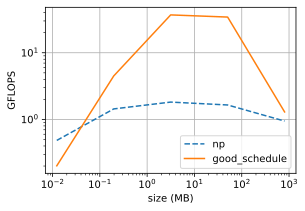

In [12]:
good_gflops = bench_broad_add_tvm(good_schedule, sizes, target)
d2ltvm.plot_gflops(x_axis_sizes, [np_gflops, good_gflops], ['np', 'good_schedule'], xlabel='size (MB)')

the performance is better and drops at a larger data size as multi-core comes into play, leading to a larger amount L2 cache in total.

# Bad Schedule

In [6]:
def bad_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
#     s[C].reorder(y, x)
    s[C].parallel(y)
    s[C].vectorize(x)
    return s, (A, B, C)

s, args = bad_schedule(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [64], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 1], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (y: int32, 0, 64) "parallel" {
    C[ramp(y, 64, 64)] = (A[ramp(0, 1, 64)] + B[ramp(y, 64, 64)])
  }
}




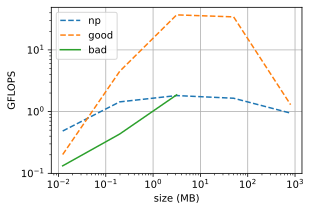

In [13]:
sizes = 2 ** np.arange(5, 11, 2)
bad_gflops = bench_broad_add_tvm(bad_schedule, sizes, target)
diff = len(good_gflops) - len(bad_gflops)
bad_gflops = np.append(bad_gflops, [np.nan] * diff)
d2ltvm.plot_gflops(x_axis_sizes, [np_gflops, good_gflops, bad_gflops], ['np', 'good', 'bad'], xlabel='size (MB)')

We can see that the performance of the vectorization-favorable schedule is pretty bad. The reason is that we access B in a stride to get the data in the same column, which is much slower than accessing data in a consecutive space. And the thread-level parallelism would make it even worse as different threads compete in getting the data in the same cache line.

# Summary
1.Like vector add, broadcast add is a memory-bound operator. \
2.A good schedule needs to consider multiple performance-related factors together.

# Exercise

In [8]:
def p_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
    s[C].parallel(x)
    return s, (A, B, C)

s, args = p_schedule(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [64], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 1], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (x: int32, 0, 64) "parallel" {
    for (y: int32, 0, 64) {
      let cse_var_1: int32 = ((x*64) + y)
      C[cse_var_1] = (A[x] + B[cse_var_1])
    }
  }
}




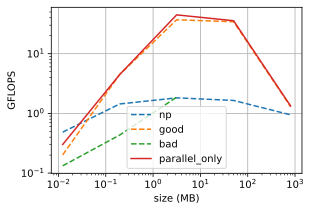

In [14]:
sizes = 2 ** np.arange(5, 15, 2)
p_gflops = bench_broad_add_tvm(p_schedule, sizes, target)
d2ltvm.plot_gflops(x_axis_sizes, [np_gflops, good_gflops, bad_gflops, p_gflops], 
                       ['np', 'good', 'bad', 'parallel_only'], xlabel='size (MB)')

In [10]:
def v_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
    s[C].vectorize(y)
    return s, (A, B, C)

s, args = v_schedule(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [64], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 1], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (x: int32, 0, 64) {
    let cse_var_1: int32 = (x*64)
    C[ramp(cse_var_1, 1, 64)] = (broadcast(A[x], 64) + B[ramp(cse_var_1, 1, 64)])
  }
}




In [19]:
v_gflops = bench_broad_add_tvm(v_schedule, sizes, target)

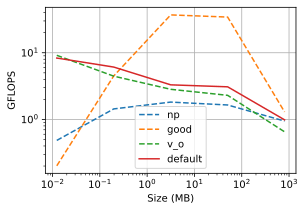

In [22]:
default_gflops = bench_broad_add_tvm(default, sizes, target)
d2ltvm.plot_gflops(x_axis_sizes, [np_gflops, good_gflops, v_gflops, default_gflops],
                  ['np', 'good', 'v_o', 'default'], xlabel='Size (MB)')